In [16]:
# Import Resale-Flat-Prices.csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
df = pd.read_csv("data/resale-flat-prices-sers-removed.csv", low_memory=False)

In [17]:
df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0
1,1990-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977,46000.0


# Data Cleaning

In [18]:
# Combine Multi-Generation and Multi Generation categories in flat type
# Report Section 3-B-1
df["flat_type"] = df["flat_type"].replace("MULTI GENERATION", "MULTI-GENERATION")
df["flat_type"].unique()

array(['3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

In [19]:
# Clean flat model column by capitalising and renaming
# Report Section 3-B-2
df["flat_model"] = df["flat_model"].replace("2-room", "2-ROOM")
df["flat_model"] = df["flat_model"].replace("2-ROOM", "2 ROOM")
df["flat_model"] = df["flat_model"].replace("3Gen", "3 GEN")
df["flat_model"] = df["flat_model"].replace("Adjoined flat", "ADJOINED FLAT")
df["flat_model"] = df["flat_model"].replace("Apartment", "APARTMENT")
df["flat_model"] = df["flat_model"].replace("Improved", "IMPROVED")
df["flat_model"] = df["flat_model"].replace("Improved-Maisonette", "IMPROVED-MAISONETTE")
df["flat_model"] = df["flat_model"].replace("IMPROVED-MAISONETTE", "IMPROVED MAISONETTE")
df["flat_model"] = df["flat_model"].replace("Maisonette", "MAISONETTE")
df["flat_model"] = df["flat_model"].replace("Model A", "MODEL A")
df["flat_model"] = df["flat_model"].replace("Model A-Maisonette", "MODEL A-MAISONETTE")
df["flat_model"] = df["flat_model"].replace("MODEL A-MAISONETTE", "MODEL A MAISONETTE")
df["flat_model"] = df["flat_model"].replace("New Generation", "NEW GENERATION")
df["flat_model"] = df["flat_model"].replace("Model A2", "MODEL A2")
df["flat_model"] = df["flat_model"].replace("MULTI GENERATION", "MULTI-GENERATION")
df["flat_model"] = df["flat_model"].replace("Multi Generation", "MULTI-GENERATION")
df["flat_model"] = df["flat_model"].replace("Premium Apartment", "PREMIUM APARTMENT")
df["flat_model"] = df["flat_model"].replace("Premium Apartment Loft", "PREMIUM APARTMENT LOFT")
df["flat_model"] = df["flat_model"].replace("Premium Maisonette", "PREMIUM MAISONETTE")
df["flat_model"] = df["flat_model"].replace("Simplified", "SIMPLIFIED")
df["flat_model"] = df["flat_model"].replace("Standard", "STANDARD")
df["flat_model"] = df["flat_model"].replace("Terrace", "TERRACE")
df["flat_model"] = df["flat_model"].replace("Type S1", "TYPE S1")
df["flat_model"] = df["flat_model"].replace("Type S2", "TYPE S2")

df["flat_model"].unique()

array(['NEW GENERATION', 'IMPROVED', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2 ROOM', 'IMPROVED MAISONETTE', 'MULTI-GENERATION',
       'PREMIUM APARTMENT', 'ADJOINED FLAT', 'PREMIUM MAISONETTE',
       'MODEL A2', 'DBSS', 'TYPE S1', 'TYPE S2', 'PREMIUM APARTMENT LOFT',
       '3 GEN'], dtype=object)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878934 entries, 0 to 878933
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                878934 non-null  object 
 1   town                 878934 non-null  object 
 2   flat_type            878934 non-null  object 
 3   block                878934 non-null  object 
 4   street_name          878934 non-null  object 
 5   storey_range         878934 non-null  object 
 6   floor_area_sqm       878934 non-null  float64
 7   flat_model           878934 non-null  object 
 8   lease_commence_date  878934 non-null  int64  
 9   resale_price         878934 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 67.1+ MB


# Data Transformation

In [21]:
# Convert lease_commence_date to remaining lease at point of transaction
# lease commencing 1976 and sale in 1990 =  1976+99-1990 = 85 years remaining
# Report Section 4-A
df["remaining_lease"] = (df["lease_commence_date"] + 99 - df["month"].str[:4].astype(int))/99
df = df.drop(columns=['lease_commence_date'])

In [22]:
# Load HDB Resale Price Index
# Report Section 5-A
hdb_resale_price_index = pd.read_csv("data/housing-and-development-board-resale-price-index-1q2009-100-monthly.csv", low_memory=False, index_col=0)
current_index = hdb_resale_price_index.tail(1)["index"].values[0]

# Calculate adjusted price
df = df.join(hdb_resale_price_index, on="month", how="left", rsuffix="_index")
df["adjusted_price"] = df["resale_price"] * (current_index / df["index"])


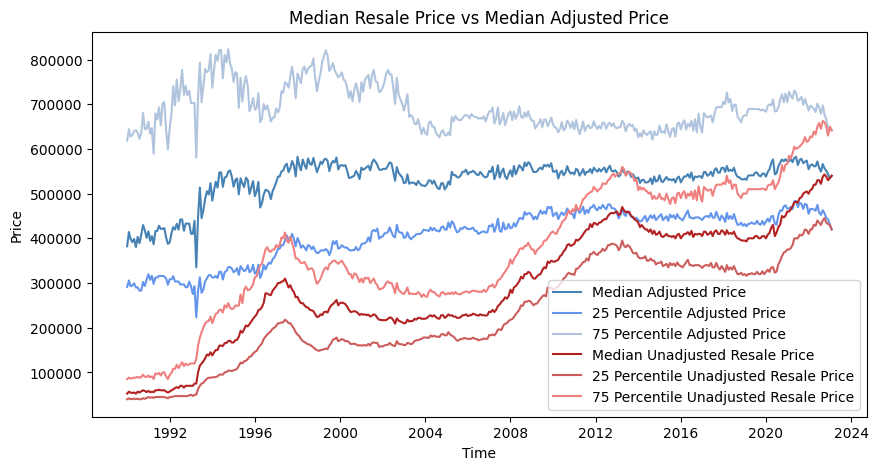

In [32]:
# Plot median adjusted price vs month
# Plot median resale price vs month

# Convert month to datetime
df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df.groupby("month")["adjusted_price"].median(), color="steelblue", label="Median Adjusted Price")
ax.plot(df.groupby("month")["adjusted_price"].quantile(0.25), color="cornflowerblue", label="25 Percentile Adjusted Price")
ax.plot(df.groupby("month")["adjusted_price"].quantile(0.75), color="lightsteelblue", label="75 Percentile Adjusted Price")
ax.plot(df.groupby("month")["resale_price"].median(), color="firebrick", label="Median Unadjusted Resale Price")
ax.plot(df.groupby("month")["resale_price"].quantile(0.25), color="indianred", label="25 Percentile Unadjusted Resale Price")
ax.plot(df.groupby("month")["resale_price"].quantile(0.75), color="lightcoral", label="75 Percentile Unadjusted Resale Price")

ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.set_title("Median Resale Price vs Median Adjusted Price")
ax.legend()
plt.show()

In [34]:
df.drop(columns=["index", "resale_price", "month"], inplace=True)

In [35]:
# Add Region Data
# Report Section 5-B
# Central = ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']
# East = ['BEDOK','PASIR RIS', 'TAMPINES']
# West = ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST']
# North East = ['ANG MO KIO','HOUGANG', 'PUNGGOL', 'SENGKANG','SERANGOON']
# North = ['SEMBAWANG', 'WOODLANDS', 'YISHUN',]

def get_region(row):
	town = row["town"]
	if town in ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']:
		return "CENTRAL"
	elif town in ['BEDOK','PASIR RIS', 'TAMPINES']:
		return "EAST"
	elif town in ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST']:
		return "WEST"
	elif town in ['ANG MO KIO','HOUGANG', 'PUNGGOL', 'SENGKANG','SERANGOON']:
		return "NORTH-EAST"
	elif town in ['SEMBAWANG', 'WOODLANDS', 'YISHUN']:
		return "NORTH"
       
df["region"] = df.apply(get_region, axis=1)


In [36]:
# Add coordinate data from block_street_name_coords.json
# Report Section 5-B
df["block_street_name"] = df["block"].astype(str) + " " + df["street_name"].astype(str)
df = df.drop(columns=['block', 'street_name'])
block_street_name_coords = pd.read_json("data/block_street_name_coords.json")
block_street_name_coords = block_street_name_coords.transpose()

df = df.join(block_street_name_coords, on="block_street_name", how="left", rsuffix="_coords")
df.drop(columns=["block_street_name"], inplace=True)

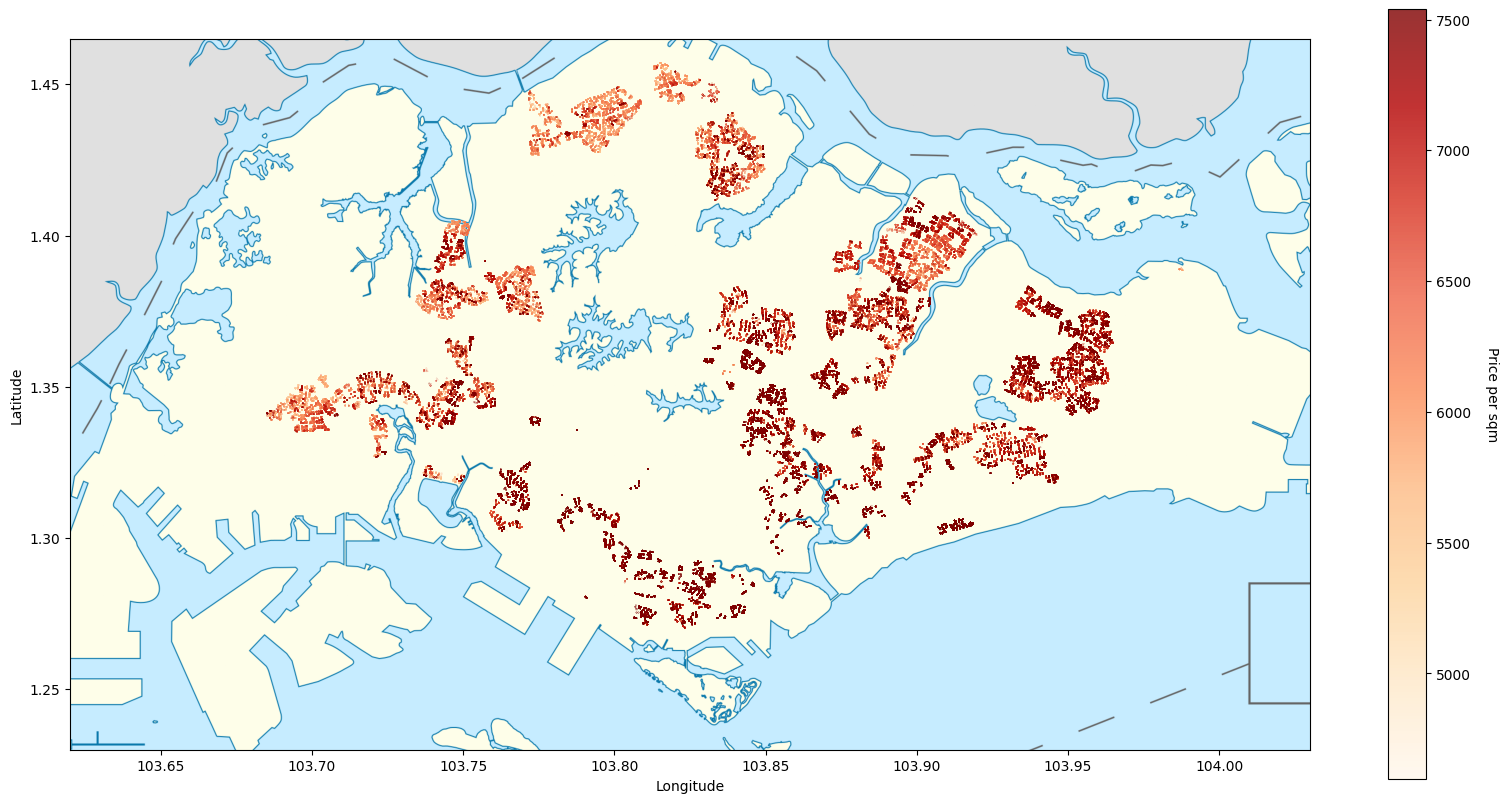

In [38]:
# Visualise data on Singapore map
import matplotlib.colors as colors
def visualise(df, vmin, vmax):
    
    df_sorted = df.sort_values(by='price_per_sqm')
    x = df_sorted['longitude']
    y = df_sorted['latitude']
    c = df_sorted['price_per_sqm'] 

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['figure.dpi'] = 100 

    # add image of singapore map
    img = plt.imread('data/3247px-Singapore_location_map_(main_island).svg.png')
    plt.imshow(img, extent=[103.557, 104.131, 1.129, 1.493])

    # set axes limits
    plt.xlim(103.62, 104.03)
    plt.ylim(1.23, 1.465)
    

    # Set axes titles
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.scatter(x, y, s=0.01, c=c, cmap='OrRd', 
                norm=colors.Normalize(vmin=vmin,vmax=vmax), alpha=0.8)
    cbar = plt.colorbar()
    cbar.set_label('Price per sqm', rotation=270, labelpad=20)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

df2 = df
df2["price_per_sqm"] = df2["adjusted_price"] / df2["floor_area_sqm"]
visualise(df2, df2["price_per_sqm"].quantile(0.10), df2["price_per_sqm"].quantile(0.90))

In [11]:
# Add distance from Downtown Core planning area (CBD)
# Report Section 5-B
# Downtown Core planning area (CBD) = 1.286667, 103.853611
dg_mrt_lat = np.radians(1.286667)
dg_mrt_long = np.radians(103.853611)

df['distance_from_cbd'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(df['latitude']) - dg_mrt_lat)/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(np.radians(df['latitude'])) * np.sin((np.radians(df['longitude']) - dg_mrt_long)/2)**2))

In [12]:
# Transform storey_range to median of range (e.g. 01 TO 03 = 2)
# Report Section 4-B-4
def convert_to_median(row):
	storey_range = row["storey_range"].split(" TO ")
	median = (int(storey_range[0]) + int(storey_range[1])) / 2
	return median

df["median_storey"] = df.apply(convert_to_median, axis=1)
df = df.drop(columns=['storey_range'])

In [13]:
# Transform flat_type to ordinal encoding, town and flat_model to one-hot encoding
# Report Section 4-B
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 

cols = ["town", "region", "longitude", "latitude","distance_from_cbd",
         "flat_type", "flat_model", "floor_area_sqm", "median_storey", "remaining_lease",
         "adjusted_price"]
df = df[cols]

pipeline = ColumnTransformer([ 
# Add normalisation for numerical columns
#    ("s", StandardScaler(), ["longitude", "latitude", "distance_from_cbd", "floor_area_sqm", "median_storey", "remaining_lease"]),
     ("o", OrdinalEncoder(), ["flat_type"]), 
     ("n", OneHotEncoder(sparse_output=False), ["town", "flat_model", "region"]), 
     ], 
     remainder='passthrough', verbose_feature_names_out=False
) 
pipeline.set_output(transform="pandas")
df = pipeline.fit_transform(df)

In [14]:
description = df.describe()

In [15]:
# Save dataframe to file
import pickle
df.to_pickle("dataframes/pre-processed.pkl")

### 